In [19]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8_tejaas_permnull_sb0.1_knn"
dhs_file = "../external/segway_encyclopedia/segway_encyclopedia_relabel_hg38_clean.bed"
tissue_file = "../tissue_table.txt"
rrfile = "trans_eqtls.txt"
outdir = "../dhs_enrichment/segway_genomebiol_2019/"

random_snp_dir = "/usr/users/sbanerj/gtex_v8/genotype/all_samples/random_sampling"

In [77]:
import numpy as np
import collections
import os
import sys

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
from utils import utils
from utils import read_tejaas_results
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 72)

In [51]:
with open(dhs_file, 'r') as infile:
    header = infile.readline()
cell_lines = header.split()[5:]

In [52]:
labels = ['Quiescent', 'ConstitutiveHet', 'FacultativeHet', 'Transcribed', 
          'Promoter', 'Enhancer', 'RegPermissive', 'Bivalent', 'LowConfidence']

In [53]:
def find_dhs_overlap(res_dict, dhs_file, outfile):
    dhs = open(dhs_file)
    line = dhs.readline()
    line = dhs.readline()
    prev_chrm = 0
    nannot = 0
    while line:
        arr = line.rstrip().split()
        chrm = int(arr[0][3:])
        start = int(arr[1])
        end = int(arr[2])
        if chrm != prev_chrm:
            remaining = res_dict[chrm]
            checked = 0
        if len(remaining) == 0:
            ## No more SNPs in this chromosome, just continue reading the DHS file
            line = dhs.readline()
        else:
            for pos in remaining:
                if pos < start:
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    continue # go to next SNP
                elif pos > end:
                    line = dhs.readline()
                    break # go to next DHS line, keep checking the remaining results
                else:
                    # this is an annotated SNP
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    nannot += 1
                    outfile.write(line)
                    continue # go to next SNP
        prev_chrm = chrm
    dhs.close()
    return nannot

In [54]:
def get_random_dhs_overlap_instance(iterdir, dhs_file, outfile):
    res_dict = dict()
    ntot = 0
    for chrm in range(1, 23):
        chrm_bppos_list = list()
        filename = os.path.join(iterdir, f'chr{chrm}.txt')
        with open(filename, 'r') as infile:
            for line in infile:
                line = line.strip()
                spos = int(line.split()[0].strip())
                chrm_bppos_list.append(spos)
                ntot += 1
        chrm_bppos_list.sort()
        res_dict[chrm] = chrm_bppos_list
    n_annotated = find_dhs_overlap(res_dict, dhs_file, outfile)
    dhs_frac = float(n_annotated) / float(ntot)
    return dhs_frac, ntot


def get_random_dhs_overlap(dirname, dhs_file, outdir, header):
    dhs_frac_rand = list()
    nlist = list()
    for i in range(10):
        iterdir = os.path.join(dirname, f'random_50000_{i+1 :02d}')
        outfile = os.path.join(outdir, 'random', f'iter{i}.txt')
        if not os.path.exists(os.path.join(outdir, 'random')):
            os.makedirs(os.path.join(outdir, 'random'))
        fout = open(outfile, 'w')
        fout.write(header)
        dhs_frac_rand_instance, n_instance = get_random_dhs_overlap_instance(iterdir, dhs_file, fout)
        fout.close()
        nlist.append(n_instance)
        dhs_frac_rand.append(dhs_frac_rand_instance)
        print (f'Iteration {i+1}. Fraction of DHS overlap = {dhs_frac_rand_instance :7.4f}')
    return np.mean(dhs_frac_rand), nlist

In [56]:
dhs_frac_rand, n_list = get_random_dhs_overlap(random_snp_dir, dhs_file, outdir, header)

Iteration 1. Fraction of DHS overlap =  0.0736
Iteration 2. Fraction of DHS overlap =  0.0774
Iteration 3. Fraction of DHS overlap =  0.0731
Iteration 4. Fraction of DHS overlap =  0.0752
Iteration 5. Fraction of DHS overlap =  0.0665
Iteration 6. Fraction of DHS overlap =  0.0747
Iteration 7. Fraction of DHS overlap =  0.0718
Iteration 8. Fraction of DHS overlap =  0.0707
Iteration 9. Fraction of DHS overlap =  0.0682
Iteration 10. Fraction of DHS overlap =  0.0637


In [60]:
Arand = np.zeros((len(labels), len(cell_lines)))
for i in range(10):
    Arand_instance = np.zeros((len(labels), len(cell_lines)))
    rand_dhs_file = os.path.join(outdir, 'random', f'iter{i}.txt')
    with open(rand_dhs_file, 'r') as infile:
        infile.readline()
        for line in infile:
            ncount += 1
            info = line.strip().split()[5:]
            for clindx, label in enumerate(info):
                labelindx = int(label)
                Arand_instance[labelindx, clindx] += 1
    Arand_instance /= n_list[0]
    Arand += Arand_instance
Arand /= 10

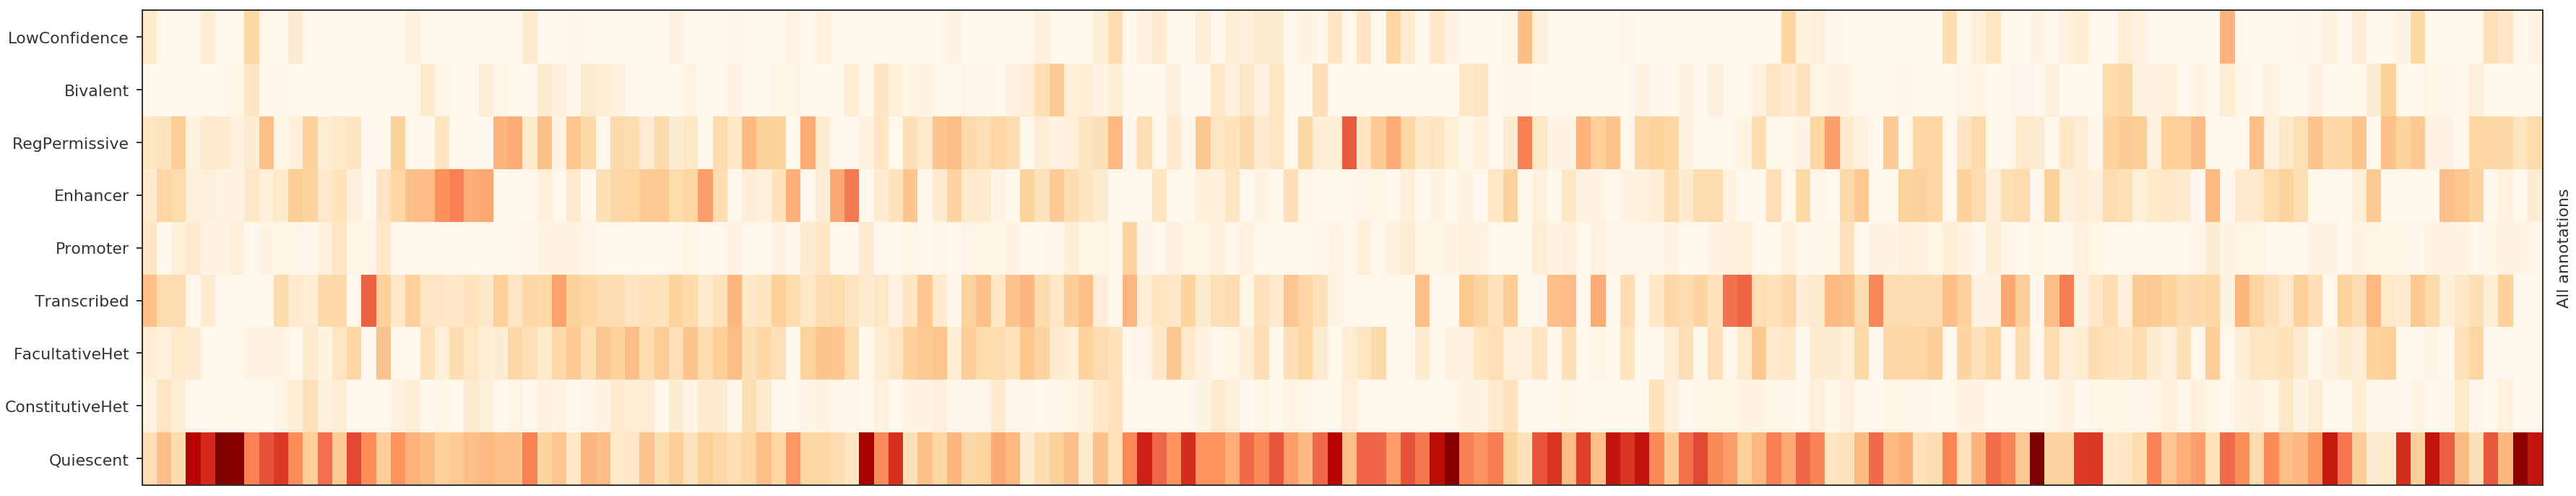

In [61]:
fig = plt.figure(figsize = (50, 10))
cmap = matplotlib.cm.get_cmap('OrRd')
cmap.set_bad('w')

ax = fig.add_subplot(111)

y, x = np.mgrid[slice(0, len(labels) + 1, 1),
                slice(0, len(cell_lines) + 1, 1)]

ax.pcolormesh(x, y, Arand, cmap=cmap)
ax.set_yticks([x + 0.5 for x in range(len(labels))])
ax.set_yticklabels(labels)
#ax.set_xticks([x + 0.5 for x in range(len(cell_lines))])
#ax.set_xticklabels(cell_lines, rotation = 'vertical', size=18)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.set_ylabel('All annotations')
plt.tight_layout()
plt.show()

In [62]:
tshorts, tfulls = utils.read_tissues(tissue_file)
#tshorts = tissuelist
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    #if tshort in tissuelist:
    tissue_names[tshort] = tfull

In [72]:
nsuff = 0
dhs_enrich_dict = dict()

for tissue in tshorts:
    resfilename = os.path.join(resdir, tissue, rrfile)
    transeqtls = read_tejaas_results.transeqtls(resfilename)
    #print(f'{tissue}: {len(transeqtls)} trans-eQTLs')
    nteqtl = len(transeqtls)

    if nteqtl > 0:
        outfile = os.path.join(outdir, f'{tissue}_segway.txt')
        fout = open(outfile, 'w')
        fout.write(header)
        res_dict = dict()
        
        for chrm in range(1, 23):
            res_dict[chrm] = list()

        for teqtl in transeqtls:
            chrm = teqtl.chrom
            spos = teqtl.bp_pos
            res_dict[chrm].append(spos)

        n_annot = get_dhs_overlap(res_dict, dhs_file, fout)
        fout.close()
        
        if n_annot > 0:
            dhs_frac = n_annot / nteqtl
            dhs_enrich = dhs_frac / dhs_frac_rand
        else:
            dhs_enrich = 0.0
        
        if dhs_enrich > 1.0: nsuff += 1
        dhs_enrich_dict[tissue] = dhs_enrich

SNPs with zero p-value: 23
SNPs with zero p-value: 16
SNPs with zero p-value: 126
SNPs with zero p-value: 48
SNPs with zero p-value: 246
SNPs with zero p-value: 230
SNPs with zero p-value: 37
SNPs with zero p-value: 42
SNPs with zero p-value: 25
SNPs with zero p-value: 32
SNPs with zero p-value: 45
SNPs with zero p-value: 69
SNPs with zero p-value: 136
SNPs with zero p-value: 53
SNPs with zero p-value: 67
SNPs with zero p-value: 178
SNPs with zero p-value: 150
SNPs with zero p-value: 30
SNPs with zero p-value: 9
SNPs with zero p-value: 4
SNPs with zero p-value: 6
SNPs with zero p-value: 44
SNPs with zero p-value: 6
SNPs with zero p-value: 59
SNPs with zero p-value: 34
SNPs with zero p-value: 4
SNPs with zero p-value: 65
SNPs with zero p-value: 1
SNPs with zero p-value: 56
SNPs with zero p-value: 9
SNPs with zero p-value: 11
SNPs with zero p-value: 13
SNPs with zero p-value: 23
SNPs with zero p-value: 9
SNPs with zero p-value: 7
SNPs with zero p-value: 44
SNPs with zero p-value: 254
SNP

In [80]:
fig = plt.figure(figsize = (50, 12 * nsuff))
nthis = 0

#for tissue, dhs_enrich in dhs_enrich_dict.items():
for tissue in list(dhs_enrich_dict)[:3]:
    
    segway_file = os.path.join(outdir, f'{tissue}_segway.txt')
    if dhs_enrich_dict[tissue] > 1.0:
        tmat = np.zeros((len(labels), len(cell_lines)))
        with open(segway_file, 'r') as infile:
            infile.readline()
            for line in infile:
                ncount += 1
                info = line.strip().split()[5:]
                for clindx, label in enumerate(info):
                    labelindx = int(label)
                    tmat[labelindx, clindx] += 1

        nthis += 1
        ax = fig.add_subplot(nsuff, 1, nthis)
        
        propmat = np.zeros((len(labels), len(cell_lines)))
        for i in range(len(labels)):
            for j in range(len(cell_lines)):
                if tmat_all[i, j] > 0:
                    propmat[i, j] = tmat[i, j] / Arand[i, j]

        y, x = np.mgrid[slice(0, len(labels) + 1, 1),
                        slice(0, len(cell_lines) + 1, 1)]

        ax.pcolormesh(x, y, propmat, cmap=cmap)
        ax.set_yticks([x + 0.5 for x in range(len(labels))])
        ax.set_yticklabels(labels)
        if nthis == nsuff:
            ax.set_xticks([x + 0.5 for x in range(len(cell_lines))])
            ax.set_xticklabels(cell_lines, rotation = 'vertical', size=18)#
        else:
            ax.set_xticks([])
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(tissue_names[tissue])

cbar = fig.colorbar(heatmap, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=label_font_size, length=10, width=borderwidth, pad=10)
cbar.outline.set_linewidth(borderwidth)
cbar.outline.set_edgecolor(bordercolor)

#outfile = os.path.join(outdir, "cell_line_specific_enrichments.png")
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [87]:
Arand = np.zeros(len(cell_lines))
allowindx = [3, 4, 5, 6, 7]
for i in range(10):
    Arand_instance = np.zeros(len(cell_lines))
    rand_dhs_file = os.path.join(outdir, 'random', f'iter{i}.txt')
    with open(rand_dhs_file, 'r') as infile:
        infile.readline()
        for line in infile:
            ncount += 1
            info = line.strip().split()[5:]
            for clindx, label in enumerate(info):
                labelindx = int(label)
                if labelindx in allowindx:
                    Arand_instance[clindx] += 1
    Arand_instance /= n_list[0]
    Arand += Arand_instance
Arand /= 10

In [ ]:
fig = plt.figure(figsize = (50, 12 * nsuff))
nthis = 0

#for tissue, dhs_enrich in dhs_enrich_dict.items():
for tissue in list(dhs_enrich_dict)[:3]:
    
    segway_file = os.path.join(outdir, f'{tissue}_segway.txt')
    if dhs_enrich_dict[tissue] > 1.0:
        tmat = np.zeros((len(labels), len(cell_lines)))
        with open(segway_file, 'r') as infile:
            infile.readline()
            for line in infile:
                ncount += 1
                info = line.strip().split()[5:]
                for clindx, label in enumerate(info):
                    labelindx = int(label)
                    tmat[labelindx, clindx] += 1

        nthis += 1
        ax = fig.add_subplot(nsuff, 1, nthis)
        
        propmat = np.zeros((len(labels), len(cell_lines)))
        for i in range(len(labels)):
            for j in range(len(cell_lines)):
                if tmat_all[i, j] > 0:
                    propmat[i, j] = tmat[i, j] / Arand[i, j]

        y, x = np.mgrid[slice(0, len(labels) + 1, 1),
                        slice(0, len(cell_lines) + 1, 1)]

        ax.pcolormesh(x, y, propmat, cmap=cmap)
        ax.set_yticks([x + 0.5 for x in range(len(labels))])
        ax.set_yticklabels(labels)
        if nthis == nsuff:
            ax.set_xticks([x + 0.5 for x in range(len(cell_lines))])
            ax.set_xticklabels(cell_lines, rotation = 'vertical', size=18)#
        else:
            ax.set_xticks([])
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(tissue_names[tissue])

cbar = fig.colorbar(heatmap, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=label_font_size, length=10, width=borderwidth, pad=10)
cbar.outline.set_linewidth(borderwidth)
cbar.outline.set_edgecolor(bordercolor)

#outfile = os.path.join(outdir, "cell_line_specific_enrichments.png")
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()